# Coordinates in Astronomy

Historically the sky was seen as the "celestial sphere" with everything at the same distance away. We're getting better at understanding true distances, but it is still  a lot easier to point at a star and say "it's in that direction".

Coordinates on a unit sphere can be specified with two angles: in Earth terms, a north-south angle either up from the equator (latitude, elevation, altitude) or down from the north pole (zenith angle); and an east-west angle around the equator (longitude, azimuth angle, right ascension). That assumes we have already defined an equator/pole and a prime meridian. These can be non-trivial decisions. 

How do we define a frame of reference for the sky? Simple choices might include:

- Origin at my current position, directions using the Earth's N-S axis and the local horizon
- Origin at the center of the Earth, directions extending Lat-Long coordinates outwards
- Origin at the Sun, directions based on the plane of the Earth's annual orbit
- Origin at either the Earth or the galactic center, directions based on the center plane of the Milky Way

And many more. The package `astropy.coordinates` provides [an alarming chart](https://astropy.readthedocs.io/en/latest/coordinates/index.html#module-astropy.coordinates) of frames it can use as standard, and makes it easy for you to add your own.

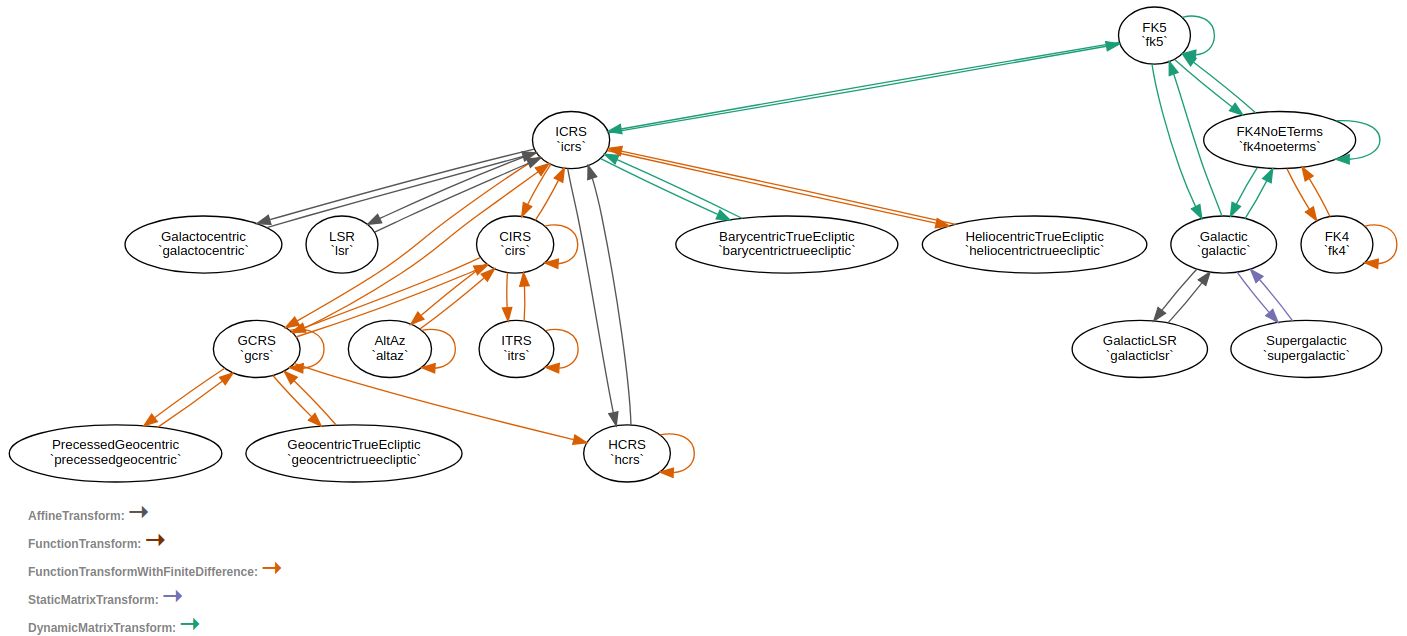

In [1]:
from urllib.parse import urlencode
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import Image

## The Equatorial System

An old and widely useful frame, this (in its original form) defines the celestial equator as an extension of Earth's equatorial plane. Declination is the angle north of this, with negative values for the southern hemisphere. The prime meridian is defined by the vernal equinox, and angles eastward from this are called Right Ascension. RA can be given in degrees, but is commonly in hours, minutes, seconds based on the Earth's spin.

We can find a bright star and display its coordinates in different frames:

In [2]:
vega = SkyCoord.from_name('vega')

In [3]:
display(vega)
display(vega.fk5)
display(vega.fk4)
display(vega.gcrs)
display(vega.cirs)

<SkyCoord (ICRS): (ra, dec) in deg
    (279.23473479, 38.78368896)>

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (279.23473986, 38.78369482)>

<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec) in deg
    (278.81472167, 38.74001462)>

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (279.22732893, 38.78334359)>

<SkyCoord (CIRS: obstime=J2000.000): (ra, dec) in deg
    (279.22875968, 38.7846798)>

Some things to notice:

- The default frame is ICRS (International Celestial Reference System)
- Default units are degrees for both Dec and RA
- Several frames give coordinates that are similar but not identical
- The SkyCoord class makes it pretty easy to interconvert

What's going on? The main problem is that the Earth isn't a great baseline for high-precision astrometry. Obviously, it spins on its axis and orbits around the Sun. Less obviously, the spin axis precesses and there are various irregular wobbles. ICRS is the latest attempt to idealize the old equatorial system to something more stable: the origin is at the barycenter of the Solar System and the orientation is defined by a set of distant radio sources (quasars, mostly). Other systems are older (FK5, FK4) or have some specialized uses (GCRS).

## Galactic Frames

The (Dec, RA) system is clearly not the only possibility:

In [4]:
display(vega)
display(vega.galactic)

<SkyCoord (ICRS): (ra, dec) in deg
    (279.23473479, 38.78368896)>

<SkyCoord (Galactic): (l, b) in deg
    (67.44820813, 19.23725227)>

What's this about? To quote the documentation for the Galactic class: 

"This frame is used in a variety of Galactic contexts because it has as its $x-y$ plane the plane of the Milky Way. The positive $x$ direction (i.e., the $l=0$, $b=0$ direction) points to the center of the Milky Way and the $z$-axis points toward the North Galactic Pole. However, unlike the Galactocentric frame, the origin of this frame in 3D space is the solar system barycenter, not the center of the Milky Way."

$l$ and $b$ are galactic longitude and latitude, respectively.

Converting to Galactocentric coordinates is more complicated, as it needs to know the full 3-D position of our star. When we did a name search for Vega in [Sesame](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame) it only returned directions from Earth; the distance is set to a meaningless default:

In [5]:
vega.distance

<Quantity 1.>

I got this to work after several attempts, but it's relatively messy:

In [6]:
import astropy.coordinates as coord
c = coord.ICRS(ra=vega.ra.deg * u.degree,
               dec=vega.dec.deg * u.degree,
               distance=7.68 * u.pc)
c.transform_to(coord.Galactocentric) 

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-8297.16690887, 6.69668726, 29.52136484)>

## Local Frames

When you are standing on top of a mountain at night, it is obviously to useful to know which objects are visible and when do they rise and set. For serious observation planning the affilated package [astroplan](https://astroplan.readthedocs.io/) is generally recommended (install it separately, it's not in Anaconda by default), but `astropy.coordinates` will do the basics.

Local frames are by definition local to a specific place and time, so these must be set first. There are several observatories within a few hours drive of my house. Of these, Kitt Peak National Observatory tends to be most visitor-friendly for the general public.

In [7]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

observing_location = EarthLocation.of_site('Kitt Peak')
display(observing_location)

current_time = Time.now()
display(current_time)

<EarthLocation (-1994502.60430614, -5037538.54232911, 3358104.99690298) m>

<Time object: scale='utc' format='datetime' value=2019-01-20 23:50:02.604048>

In [8]:
from astropy.coordinates import AltAz

aa_now = AltAz(location=observing_location, obstime=current_time)
display(aa_now)
display(vega.transform_to(aa_now))

<AltAz Frame (obstime=2019-01-20 23:50:02.604048, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

<SkyCoord (AltAz: obstime=2019-01-20 23:50:02.604048, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (303.09494096, 21.78094276)>

The last figure (alt) will show whether Vega is currently above (+ve) or below (-ve) the horizon.

For reproducibility it would be better to set a specific date and time (today as I enter this, 6pm MST, shortly after sunset, though it's entered as UTC time 7 hours later). Better still, let's use an array of times spanning the whole night, plus a second object in a different part of the sky:

In [9]:
m31 = SkyCoord.from_name('M31')

In [10]:
observing_time = Time('2019-01-21 1:00')
delta_hours = np.linspace(0, 12, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_aa_frames = AltAz(location=observing_location, obstime=full_night_times)
full_night_aa_vega = vega.transform_to(full_night_aa_frames)
full_night_aa_m31 = m31.transform_to(full_night_aa_frames)

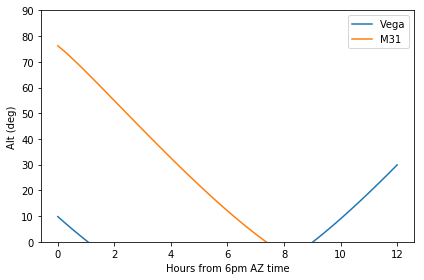

In [11]:
plt.plot(delta_hours, full_night_aa_vega.alt, label='Vega')
plt.plot(delta_hours, full_night_aa_m31.alt, label='M31')
plt.xlabel('Hours from 6pm AZ time')
plt.ylabel('Alt (deg)')
plt.ylim(0, 90)
plt.legend()
plt.tight_layout()

So our best chance to see these is probably early in the night for M31 and shortly before dawn for Vega (or wait till summer when it's high in the night sky).

This plot shows altitude: angle above the horizon. Another option, when your object is up, is `secz`: a measure of the airmass in front of the telescope.

## Ecliptic Frames

Because the planets have near-coplanar orbits, it can be useful to use this as the fundamental plane for a coordinate system when describing solar system objects. Using it for a star like Vega is technically possible but also pointless.

In [12]:
display(vega.geocentrictrueecliptic)
display(vega.barycentrictrueecliptic)
# display(vega.heliocentrictrueecliptic)

<SkyCoord (GeocentricTrueEcliptic: equinox=J2000.000): (lon, lat, distance) in (deg, deg, )
    (285.30421816, 61.73328933, 1.)>

<SkyCoord (BarycentricTrueEcliptic: equinox=J2000.000): (lon, lat) in deg
    (285.31639539, 61.7328537)>

More usefully, `astropy.coordinates` has some of the major Solar System bodies built in. Planets move around the sky (by definition), so we need to provide our time and place as with the AltAz system.

It defaults to the Geocentric Celestial Reference System (GCRS), with coordinates (ra, dec, distance).

In [13]:
from astropy.coordinates import solar_system_ephemeris, get_body, get_moon

with solar_system_ephemeris.set('builtin'):
    jup = get_body('jupiter', observing_time, observing_location)
    venus = get_body('venus', observing_time, observing_location)
    moon = get_moon(observing_time, observing_location)
display(jup, venus, moon)

<SkyCoord (GCRS: obstime=2019-01-21 01:00:00.000, obsgeoloc=(4983379.78990905, 2140392.13240407, 3349082.22703598) m, obsgeovel=(-156.08575918, 362.94779854, 0.29380827) m / s): (ra, dec, distance) in (deg, deg, AU)
    (254.35351998, -22.03315274, 5.99546318)>

<SkyCoord (GCRS: obstime=2019-01-21 01:00:00.000, obsgeoloc=(4983379.78990905, 2140392.13240407, 3349082.22703598) m, obsgeovel=(-156.08575918, 362.94779854, 0.29380827) m / s): (ra, dec, distance) in (deg, deg, AU)
    (253.21754912, -19.43250839, 0.78667658)>

<SkyCoord (GCRS: obstime=2019-01-21 01:00:00.000, obsgeoloc=(4983379.78990905, 2140392.13240407, 3349082.22703598) m, obsgeovel=(-156.08575918, 362.94779854, 0.29380827) m / s): (ra, dec, distance) in (deg, deg, km)
    (120.93330301, 20.16510922, 357430.97264288)>

These bodies can be converted to ecliptic coordinates more meaningfully than distant objects.

Note the very small latitudes for each body, confirming they are near the ecliptic plane. Especially the Moon - entirely coincidentally, I ran this a few hours before a total lunar eclipse (a "Super Blood Wolf Moon" in the newspaper headlines).

In [14]:
display(jup.geocentrictrueecliptic, venus.geocentrictrueecliptic, moon.geocentrictrueecliptic)

<SkyCoord (GeocentricTrueEcliptic: equinox=J2000.000): (lon, lat, distance) in (deg, deg, AU)
    (252.94651322, 0.60147592, 6.18538977)>

<SkyCoord (GeocentricTrueEcliptic: equinox=J2000.000): (lon, lat, distance) in (deg, deg, AU)
    (238.52413797, 2.38046298, 1.01415248)>

<SkyCoord (GeocentricTrueEcliptic: equinox=J2000.000): (lon, lat, distance) in (deg, deg, km)
    (198.59971545, -0.04934565, 49879726.23709369)>